0:	learn: 0.5490819	test: 0.5597907	best: 0.5597907 (0)	total: 1.07s	remaining: 8m 55s
100:	learn: 0.5513528	test: 0.5622820	best: 0.5627803 (70)	total: 1m 29s	remaining: 5m 53s
200:	learn: 0.5649127	test: 0.5630294	best: 0.5637768 (199)	total: 3m 12s	remaining: 4m 47s
300:	learn: 0.5725037	test: 0.5612855	best: 0.5637768 (199)	total: 5m 17s	remaining: 3m 29s
400:	learn: 0.5782132	test: 0.5622820	best: 0.5637768 (199)	total: 7m 27s	remaining: 1m 50s
499:	learn: 0.5829495	test: 0.5635277	best: 0.5637768 (199)	total: 9m 27s	remaining: 0us

bestTest = 0.5637767813
bestIteration = 199

Shrink model to first 200 iterations.
Test Accuracy: 0.56


C:\Users\athul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\athul\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.54      0.77      0.64      1727
           1       0.60      0.64      0.62      1461
           2       0.00      0.00      0.00       799
         >60       0.00      0.00      0.00         4
           3       0.00      0.00      0.00        23

    accuracy                           0.56      4014
   macro avg       0.23      0.28      0.25      4014
weighted avg       0.45      0.56      0.50      4014



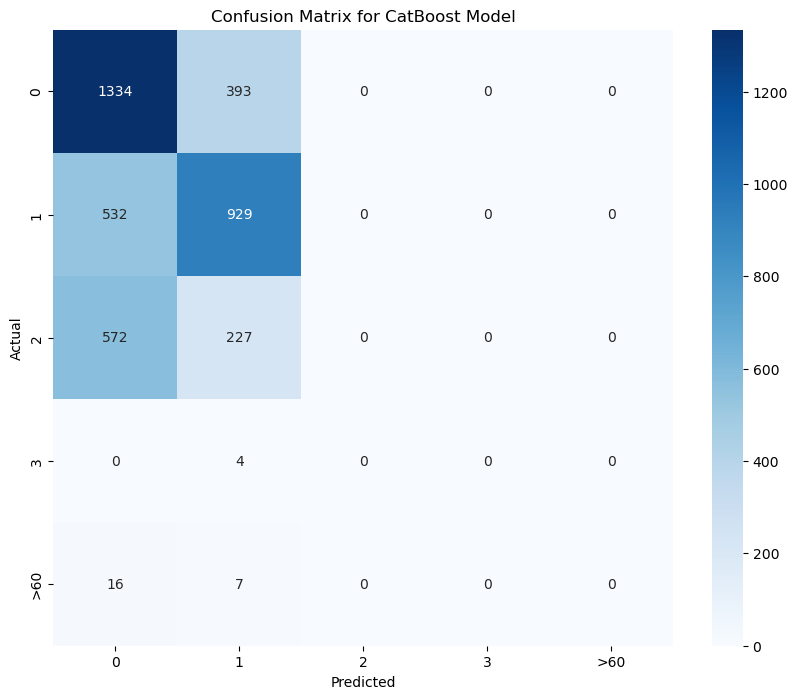

In [4]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import classification_report, accuracy_score

# Load the training and testing data
train_data = pd.read_csv('C:/Users/athul/OneDrive/Desktop/final_train_2.csv')
test_data = pd.read_csv('C:/Users/athul/OneDrive/Desktop/final_test_2.csv')

# Separate features (X) and target (y) in the training data
X_train = train_data.drop(columns=['Target'])  # Replace 'Target' with the actual column name of your target
y_train = train_data['Target']

# Separate features (X) and target (y) in the testing data
X_test = test_data.drop(columns=['Target'])  # Replace 'Target' with the actual column name of your target
y_test = test_data['Target']

# Identify categorical features (replace this with the indices or column names of your categorical variables)
categorical_features = [col for col in X_train.columns if X_train[col].dtype == 'object']

# Create CatBoost datasets
train_pool = Pool(data=X_train, label=y_train, cat_features=categorical_features)
test_pool = Pool(data=X_test, label=y_test, cat_features=categorical_features)

# Initialize and train the CatBoostClassifier
model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.01,
    depth=8,
    loss_function='MultiClass',
    eval_metric='Accuracy',
    verbose=100,
    random_seed=42
)

model.fit(train_pool, eval_set=test_pool, use_best_model=True)

# Predict on the test data
y_pred = model.predict(test_pool)
y_pred_proba = model.predict_proba(test_pool)

# Evaluate the model
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Classification report
print(classification_report(y_test, y_pred, target_names=[str(label) for label in y_test.unique()]))

# Create a DataFrame with the predictions and actual target values
results_df = pd.DataFrame({
    'Actual_Target': y_test.values,
    'Predicted_Target': y_pred.flatten()  # Flatten because CatBoost outputs a 2D array
})

# Optionally, add the original test features for reference
final_df = pd.concat([X_test.reset_index(drop=True), results_df], axis=1)

# Save the results to a CSV file for review
final_df.to_csv('C:/Users/athul/OneDrive/Desktop/test_predictions_with_target_catboost.csv', index=False)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=model.classes_, 
            yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for CatBoost Model')
plt.show()


                                   Feature  Importance (Gain)
30                            prev_1_month          31.403488
24                       unemployment rate          11.964202
29                           count_default           9.455832
31                            prev_2_month           9.122297
32                            prev_3_month           9.096961
8                   ORIGINAL INTEREST RATE           2.477217
0                             CREDIT SCORE           2.474971
26                                      CU           2.405074
5                         OCCUPANCY STATUS           1.923246
28                                Index_SA           1.840668
19                                LOAN AGE           1.756685
27                                     GDP           1.640395
15                           servicer_name           1.632618
23                    INTEREST BEARING UPB           1.461193
25                           H Value Index           1.395879
12      

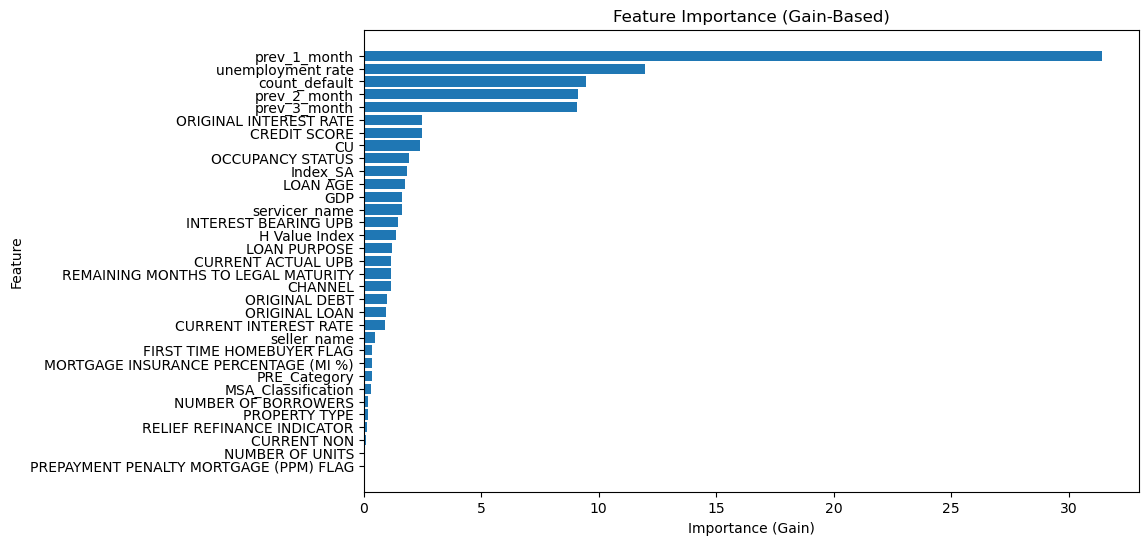

In [7]:
# Extract gain-based feature importance
feature_importances = model.get_feature_importance(train_pool, type='FeatureImportance')

# Combine feature names with their importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance (Gain)': feature_importances
}).sort_values(by='Importance (Gain)', ascending=False)

# Display the top features
print(feature_importance_df)

# Plot gain-based feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance (Gain)'])
plt.xlabel('Importance (Gain)')
plt.ylabel('Feature')
plt.title('Feature Importance (Gain-Based)')
plt.gca().invert_yaxis()  # Reverse the order for readability
plt.show()
